In [5]:
import math
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [9]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

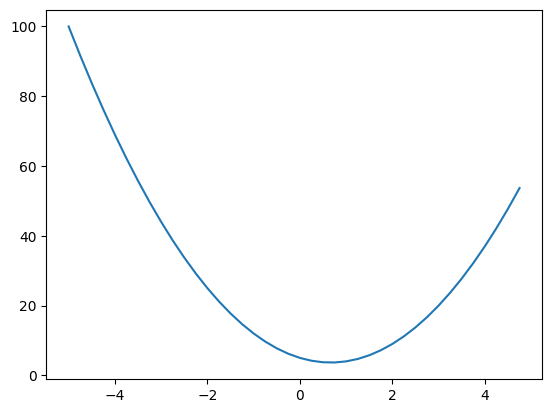

In [13]:
plt.plot(xs, ys)

In [17]:
x = 5
a = 0.001

# Derivative of f wrt x
(f(x + a) - f(x))/a

26.003000000002885

In [23]:
# inputs
a = 3.0
b = 1.2
c = 12.7

d = a*b + c

d

16.299999999999997

In [24]:
# derivative of d
h = 0.00001

d1 = a*b + c
a += h
d2 = a*b+c

slope = (d2 - d1)/h
slope

1.2000000001677336

Building the value functionality of micrograd

In [3]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f"**{other}")
        def _backward():
            self.grad += other + self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __rmul__(self, other):
        return self*other

    def __radd__(self, other):
        return self+other

    def exp(self):
        x = self.data
        exp = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1-t**2) * out.grad

        out._backward  = _backward
        
        return out

    def backward(self):
        top = []
        visited = set()
        def build_top(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_top(child)
            top.append(v)
        build_top(self)

        self.grad = 1.0
        for node in reversed(top):
            node._backward()    


In [17]:
11.0 * Value(1)

Value(data=11.0)

Multi-layer perceptron

In [11]:
# Inputs
x1 = Value(3.0, label='x1')
x2 = Value(1.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.7, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()

In [12]:
o.backward()

In [104]:
x1w1x2w2._backward()

In [13]:
x1w1.grad

0.2574331967030943

## PyTorch version

In [2]:
import torch
import random

In [9]:
x1 = torch.Tensor([1.73]).double()      ; x1.requires_grad = True
x2 = torch.Tensor([2.0]).double()      ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()      ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()      ; w2.requires_grad = True
b = torch.Tensor([6.583314]).double()      ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()


0.9977450077011144


0.004504899607503155


In [436]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
n = MLP(3, [4, 4, 1])

In [437]:
n.parameters()

[Value(data=0.7523757155997859),
 Value(data=-0.12324910036306358),
 Value(data=-0.5558785831820632),
 Value(data=-0.29471247507974985),
 Value(data=0.46738931622783797),
 Value(data=-0.09477385525333881),
 Value(data=-0.7619414839662588),
 Value(data=-0.6891307379458389),
 Value(data=-0.4168289945536052),
 Value(data=0.6023386484402096),
 Value(data=-0.8467431069001392),
 Value(data=-0.9282307933524243),
 Value(data=0.798082016424396),
 Value(data=0.8702531214523459),
 Value(data=-0.8705004843424649),
 Value(data=0.36108772253992205),
 Value(data=0.732776469694874),
 Value(data=-0.7818030914264202),
 Value(data=0.7697594474878773),
 Value(data=0.1439249158357534),
 Value(data=0.614083959346226),
 Value(data=-0.8069279012859822),
 Value(data=0.7031091198709412),
 Value(data=0.3527826132134517),
 Value(data=0.49695035509929664),
 Value(data=-0.10060365967998153),
 Value(data=0.5213461736072829),
 Value(data=0.5700076363100868),
 Value(data=-0.028710490312522374),
 Value(data=0.858729646

In [438]:
xs = [
    [1.0, 4.2, -2.3],
    [2.3, 1.3, 1.3],
    [4.3, -2.1, 3.2],
    [1.1, 2.3, -0.3],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [468]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9994593614633938),
 Value(data=-0.9962840382338322),
 Value(data=-0.9942026466140897),
 Value(data=-0.999226124783729)]

In [469]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.994790253839497)

In [470]:
loss.backward()

In [471]:
loss

Value(data=7.994790253839497)

In [472]:
n.layers[0].neurons[0].w[0].grad

-2.9787245494330548

In [473]:
n.layers[0].neurons[0].w[0].data

1.1980217152398531

In [474]:
for p in n.parameters():
    p.data += -0.05 * p.grad